In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.21.5
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

In [3]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]

# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)


['/test', '/train', '/valid']
(63311, 15)
(63311,)


In [4]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
valid_x_scaled = scaler.fit_transform(valid_x)
test_x_scaled  = scaler.fit_transform(test_x)

train_x_scaled[:,0:3] = train_x[:,0:3]
train_x_scaled[:,-5:-1] = train_x[:,-5:-1]
valid_x_scaled[:,0:3]   = valid_x[:,0:3]
valid_x_scaled[:,-5:-1] = valid_x[:,-5:-1]
test_x_scaled[:,0:3]    = test_x[:,0:3]
test_x_scaled[:,-5:-1]  = test_x[:,-5:-1]

In [ ]:
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

model = WideDeepModel()
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])

model.build(input_shape=(None, train_x_scaled.shape[1:][0]))
        
model.summary()
model.compile(loss="mean_squared_error",
              optimizer = keras.optimizers.SGD(0.001))

In [40]:
# 多输入
wide_index = [0,3]
deep_index = [3,3]
train_x_scaled_wide = train_x_scaled[:,wide_index[0]:wide_index[1]]
train_x_scaled_deep = train_x_scaled[:,deep_index[0]:]
valid_x_scaled_wide = valid_x_scaled[:,wide_index[0]:wide_index[1]]
valid_x_scaled_deep = valid_x_scaled[:,deep_index[0]:]
test_x_scaled_wide  = test_x_scaled[:,wide_index[0]:wide_index[1]]
test_x_scaled_deep  = test_x_scaled[:,deep_index[0]:]


input_wide = keras.layers.Input(shape=[train_x_scaled_wide.shape[1:][0]])
input_deep = keras.layers.Input(shape=[train_x_scaled_deep.shape[1:][0]])

hidden_loop = keras.layers.Dense(30, activation='selu')(input_deep)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
# hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
hidden_loop = keras.layers.AlphaDropout(rate=0.4)(hidden_loop)
hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
hidden_loop = keras.layers.AlphaDropout(rate=0.5)(hidden_loop)
hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
hidden_loop = keras.layers.AlphaDropout(rate=0.6)(hidden_loop)
hidden_loop = keras.layers.Dense(30, activation='selu')(hidden_loop)
hidden_loop = keras.layers.AlphaDropout(rate=0.7)(hidden_loop)
# for _ in range(10):
#   hidden_loop = keras.layers.Dense(30, activation='relu')(hidden_loop)


concat = keras.layers.concatenate([input_wide, hidden_loop])
concat2 = keras.layers.Dense(6)(concat)
output = keras.layers.Dense(1)(concat2)
model = keras.models.Model(inputs = [input_wide, input_deep],
                           outputs = [output])
        

model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]
model.summary()



Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 30)           390         input_26[0][0]                   
__________________________________________________________________________________________________
alpha_dropout_16 (AlphaDropout) (None, 30)           0           dense_101[0][0]                  
__________________________________________________________________________________________________
dense_102 (Dense)               (None, 30)           930         alpha_dropout_16[0][0]           
___________________________________________________________________________________________

In [ ]:
'''
# 函数式API 功能API
input = keras.layers.Input(shape=train_x_scaled.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 复合函数: f(x) = h(g(x))

concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input],
                           outputs = [output])

model.summary()
model.compile(loss="mean_squared_error",
              optimizer = keras.optimizers.SGD(0.001))
'''

In [41]:
# H:/github/python/seafog/
logdir = './callbacks_reg_wd_multi'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4),
    ]
history = model.fit(
                    [train_x_scaled_wide,train_x_scaled_deep],
                    train_y, 
                    epochs=100,
                    validation_data=([valid_x_scaled_wide,valid_x_scaled_deep], valid_y),
                    callbacks = model_callbacks
                    )

Epoch 1/100
1979/1979 [==============================] - 7s 4ms/step - loss: 0.6679 - val_loss: 0.5409
Epoch 2/100
1979/1979 [==============================] - 7s 3ms/step - loss: 0.6417 - val_loss: 0.4631
Epoch 3/100
1979/1979 [==============================] - 7s 3ms/step - loss: 0.6388 - val_loss: 0.4109
Epoch 4/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.6339 - val_loss: 0.5399
Epoch 5/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.6148 - val_loss: 2.1641
Epoch 6/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.5697 - val_loss: 11.4395
Epoch 7/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.5222 - val_loss: 18.3974
Epoch 8/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.4931 - val_loss: 20.1436
Epoch 9/100
1979/1979 [==============================] - 6s 3ms/step - loss: 0.4720 - val_loss: 29.8760
Epoch 10/100
1979/1979 [==============================] - 6s 3ms/step

In [ ]:
type(history)

In [ ]:
history.history

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [33]:
model.evaluate([test_x_scaled_wide,test_x_scaled_deep], test_y, verbose=0)

73.94322204589844

* 默认wide and deep 模型 MSE 0.31

In [34]:
predictions = model([test_x_scaled_wide,test_x_scaled_deep]).numpy()
predictions

array([[-8.886533],
       [-8.942505],
       [-8.863537],
       ...,
       [11.218258],
       [16.87292 ],
       [17.113884]], dtype=float32)

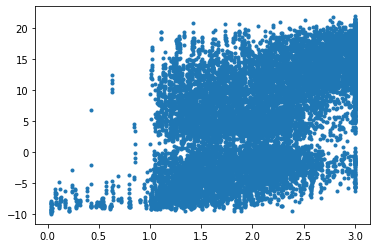

In [35]:
plt.plot(test_y, predictions,'.')
plt.show()

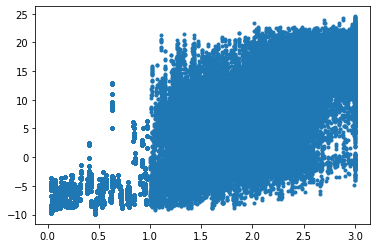

In [38]:
plt.plot(train_y,model([train_x_scaled_wide,train_x_scaled_deep]).numpy(),'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

In [ ]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 